#  Context

The FER (Facial Expression Recognition) dataset, specifically the FER2013 dataset, was created for the "Challenges in Representation Learning: Facial Expression Recognition Challenge." This challenge was part of the International Conference on Machine Learning (ICML) in 2013.

The FER2013 dataset was collected and curated by a team of researchers. The dataset consists of facial images annotated with seven different emotions: anger, disgust, fear, happiness, sadness, surprise, and neutral. It has been widely used as a benchmark dataset for training and evaluating facial expression recognition models.

The dataset has contributed to the advancement of research in facial expression recognition and machine learning. Researchers and practitioners often use it to develop and test algorithms for emotion classification based on facial expressions.

The aim to explore facial emotion recognition techniques from a live webcam video stream.

# General imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras

In [3]:
# Install required libraries (if not already installed)
!pip install keras tensorflow

In [4]:
!pip install keras tensorflow scikit-learn h5py

In [46]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import to_categorical
from keras.regularizers import l2#, activity_l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras import models
from keras.utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle


#  II. Import data

In [6]:
path = '/content/drive/MyDrive/Project/Image Dataset/'

In [7]:
pd.options.mode.chained_assignment = None  # default='warn'  #to suppress SettingWithCopyWarning

#Reading the dataset
dataset = pd.read_csv(path + 'fer2013.csv')

#Obtaining train data where usage is "Training"
train = dataset[dataset["Usage"] == "Training"]

#Obtaining test data where usage is "PublicTest"
test = dataset[dataset["Usage"] == "PublicTest"]

#Converting " " separated pixel values to list
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

In [8]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [10]:
dataset[dataset['emotion'] == 1].head()

,emotion,pixels,Usage
299,1,126 126 129 120 110 168 174 172 173 174 170 15...,Training
388,1,89 55 24 40 43 48 53 55 59 41 33 31 22 32 42 4...,Training
416,1,204 195 181 131 50 50 57 56 66 98 138 161 173 ...,Training
473,1,14 11 13 12 41 95 113 112 111 122 132 137 142 ...,Training
533,1,18 25 49 75 89 97 100 100 101 103 105 107 107 ...,Training


In [11]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = dataset['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


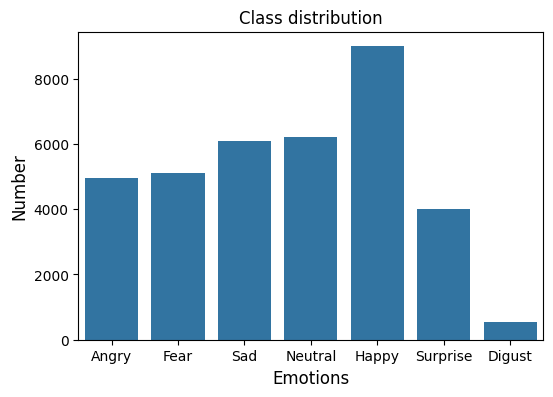

In [15]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

Let's look at some images...

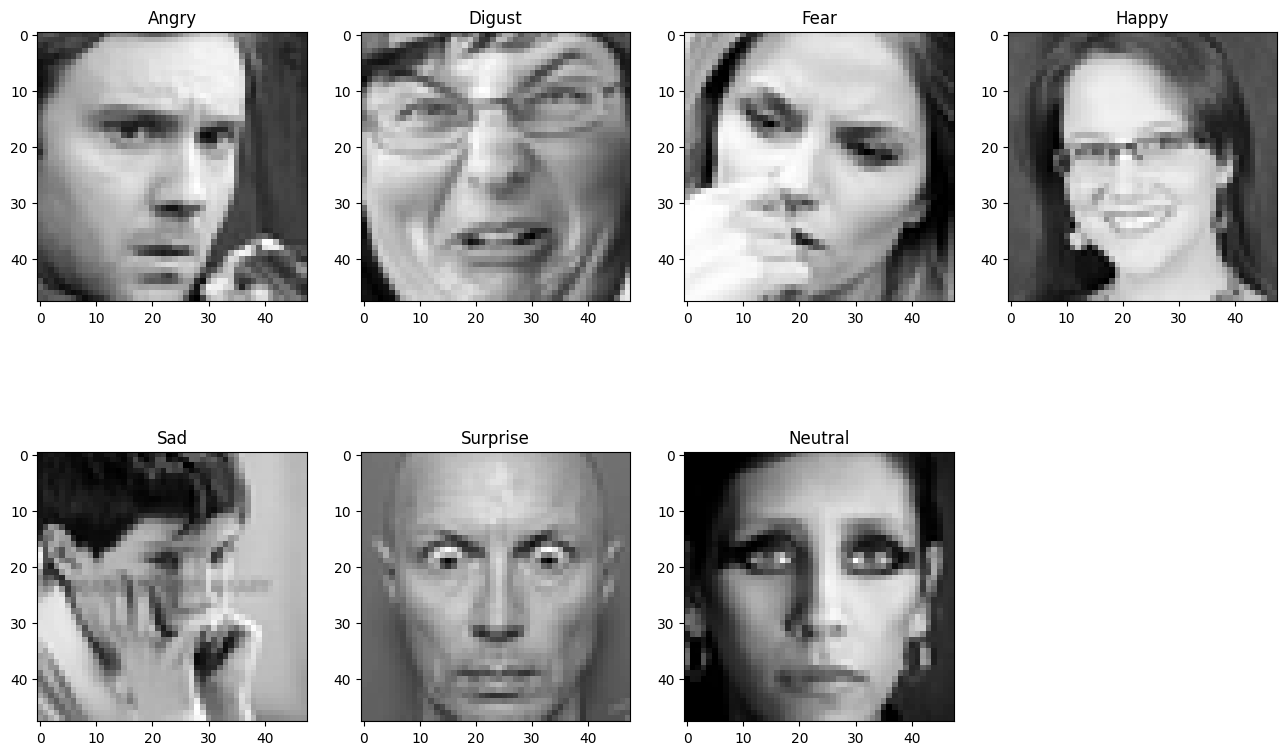

In [16]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split(), dtype=np.uint8)
    img = img.reshape(48, 48)
    return img, emotion

plt.figure(0, figsize=(16, 10))
for i in range(1, 8):
    face = dataset[dataset['emotion'] == i-1].iloc[0]
    img, emotion = row2image(face)
    plt.subplot(2, 4, i)
    plt.imshow(img, cmap='gray')  # Assuming grayscale image
    plt.title(emotion)

plt.show()



# III  Pre-processing data

Summary:
* Splitting dataset into 3 parts: train, validation, test
* Convert strings to lists of integers
* Reshape to 48x48 and normalise grayscale image with 255.0
* Perform one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

In [17]:
train.shape


(28709, 3)

In [18]:
test.shape

(3589, 3)

In [19]:
shape_x = 48
shape_y = 48

In [20]:
X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

#np.vstack stack arrays in sequence vertically (picking element row wise)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

#Reshape X_train, y_train,X_test,y_test in desired formats
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

print("Shape of X_train and y_train is " + str(X_train.shape) +" and " + str(y_train.shape) +" respectively.")
print("Shape of X_test and y_test is " + str(X_test.shape) +" and " + str(y_test.shape) +" respectively.")

Shape of X_train and y_train is (28709, 48, 48, 1) and (28709, 1) respectively.
Shape of X_test and y_test is (3589, 48, 48, 1) and (3589, 1) respectively.


In [21]:
# Change to float datatype
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')

# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

# V. Define the number of classes

In [22]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)

Total number of outputs :  7
Output classes :  [0 1 2 3 4 5 6]


In [23]:
#Defining labels
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

<ipython-input-24-b9451fbc08c0>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title("Ground Truth : {}".format(get_label(int(y_train[0]))))
<ipython-input-24-b9451fbc08c0>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title("Ground Truth : {}".format(get_label(int(y_test[1500]))))


Text(0.5, 1.0, 'Ground Truth : Surprise')

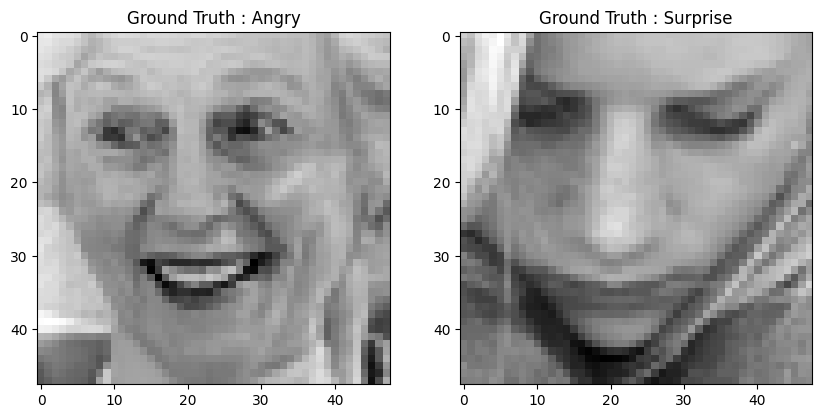

In [24]:
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(np.squeeze(X_train[25,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[0]))))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(np.squeeze(X_test[26,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[1500]))))

# VI. Detect Faces

First of all, we need to detect the faces inside an image. This will allow us to :
- focus on the region of the face
- stop the prediction if no face is recognized.

To do so, we use OpenCV faceCascade classifier. Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.

The term "Cascade" comes from the fact that when a window is explored and no face edge is identified, the region is left apart and we move on to the next one using Adaboost classifier. This makes the overall process very efficient.

In [25]:
def detect_face(frame):

    #Cascade classifier pre-trained model
    cascPath = '/usr/local/lib/python3.7/site-packages/cv2/data/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)

    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []

    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            #cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 255,255),1)
            coord.append([x,y,w,h])

    return gray, detected_faces, coord

In [26]:


def detect_face(frame):
    # Cascade classifier pre-trained model
    cascPath = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)

    # BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []

    for x, y, w, h in detected_faces:
        if w > 100:
            sub_img = frame[y:y+h, x:x+w]
            # cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 1)
            coord.append([x, y, w, h])

    return gray, detected_faces, coord


In [27]:
#Extraire les features faciales
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]

    new_face = []

    for det in detected_face :
        #Region dans laquelle la face est détectée
        x, y, w, h = det
        #X et y correspondent à la conversion en gris par gray, et w, h correspondent à la hauteur/largeur

        #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
        horizontal_offset = int(np.floor(offset_coefficients[0] * w))
        vertical_offset = int(np.floor(offset_coefficients[1] * h))

        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #gray transforme l'image
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]

        #Zoom sur la face extraite
        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
        #cast type float
        new_extracted_face = new_extracted_face.astype(np.float32)
        #scale
        new_extracted_face /= float(new_extracted_face.max())
        #print(new_extracted_face)

        new_face.append(new_extracted_face)

    return new_face

Initial picture :

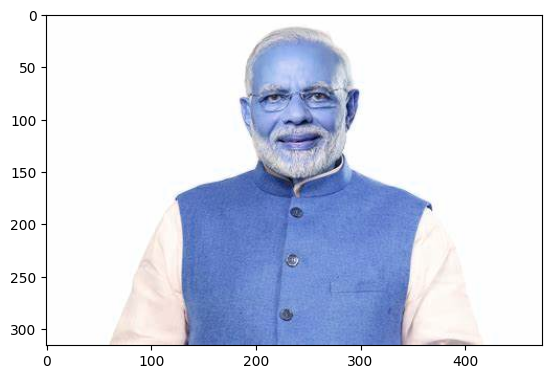

In [28]:
trump = '/content/drive/MyDrive/Project/Image Dataset/Modi.jpeg'
trump_face = cv2.imread(trump, cv2.COLOR_BGR2RGB)
plt.imshow(trump_face)

Extracted face :

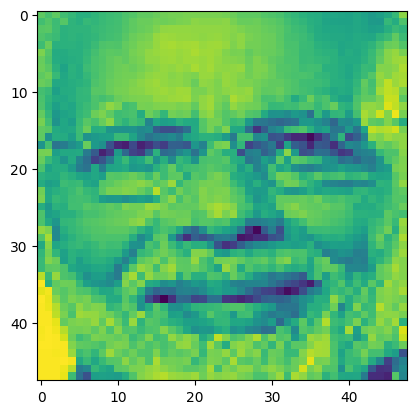

In [29]:
face = extract_face_features(detect_face(trump_face))[0]
plt.imshow(face)

# VII. Deep Learning Model architectures

## 1. Simple model
## 2. Inception
## 3. X-Ception

## 1. Simple model

In [31]:
def createModel():

    #Model Initialization
    model = Sequential()

    #Adding Input Layer
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))

    #Adding more layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #Flattening
    model.add(Flatten())

    #Adding fully connected layer
    model.add(Dense(512, activation='relu'))

    model.add(Dropout(0.6))

    #Adding Output Layer
    model.add(Dense(nClasses, activation='softmax'))

    return model

### 1.2. Prevent Overfitting

In [32]:
def createModel2():

    #Model Initialization
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))

    #Flattening
    model.add(Flatten())

    #Adding fully connected layer
    model.add(Dense(512, activation='relu'))

    #Adding Output Layer
    model.add(Dense(nClasses, activation='softmax'))

    return model

### 1.3. Go Deeper

In [33]:
def createModel3():

    #Model Initialization
    model = Sequential()

    model.add(Conv2D(20, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(30, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(40, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(50, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(60, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(70, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(80, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(90, (3, 3), padding='same', activation='relu'))

    #Flattening
    model.add(Flatten())

    #Adding fully connected layer
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(512, activation='relu'))

    #Adding Output Layer
    model.add(Dense(nClasses, activation='softmax'))

    return model

### 1.4. Build Model

In [34]:
model = createModel3()

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 20)        200       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 30)        5430      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 30)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 24, 24, 30)        120       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 24, 24, 30)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 40)        1

And visualize the model architecture :

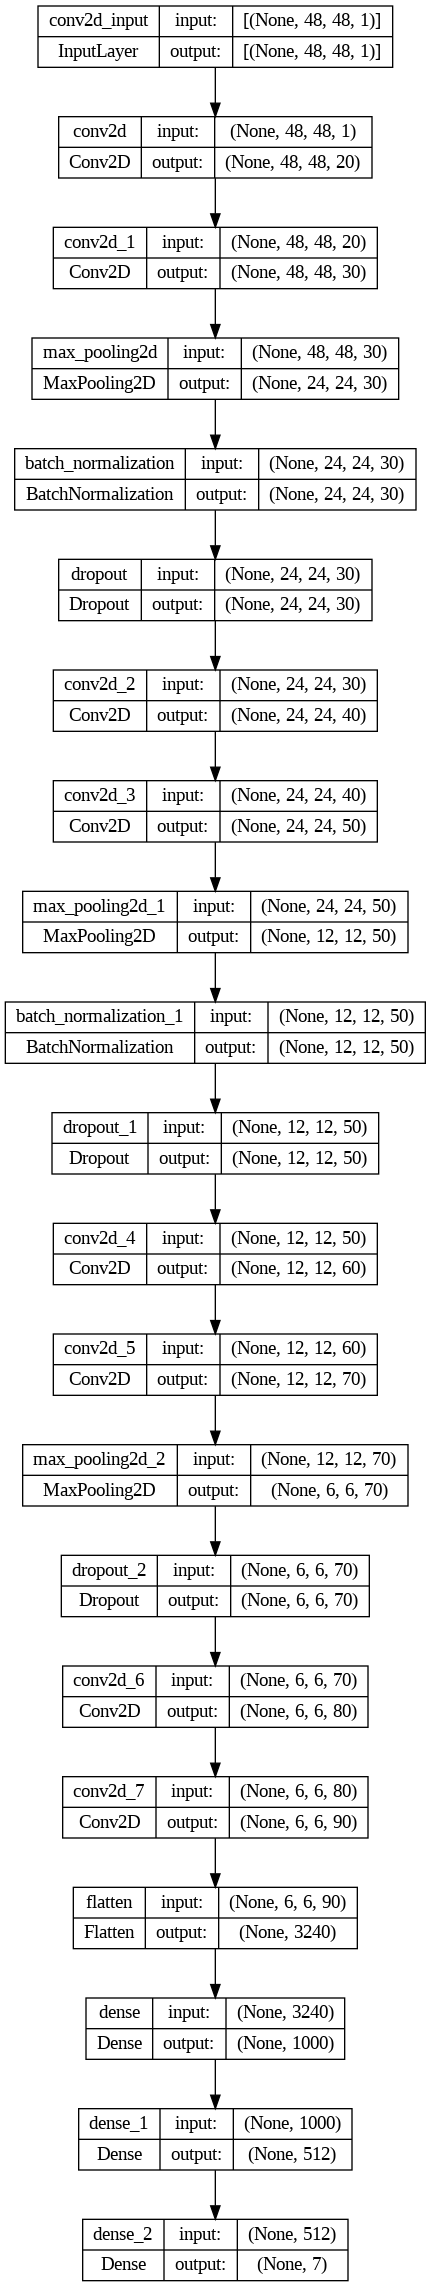

In [47]:
plot_model(model, to_file='/content/drive/MyDrive/Project/Image Dataset/model_plot.png', show_shapes=True, show_layer_names=True)

### 1.5 Visualize layers and output

In [48]:
layer_outputs = [layer.output for layer in model.layers[:12]]
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [49]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

images_per_row = 16

In [50]:
trump = '/content/drive/MyDrive/Project/Image Dataset/Modi.jpeg'
trump_face = cv2.imread(trump)
face = extract_face_features(detect_face(trump_face))[0]

to_predict = np.reshape(face.flatten(), (1,48,48,1))
res = model.predict(to_predict)
activations = activation_model.predict(to_predict)

1/1 [==============================] - 0s 144ms/step


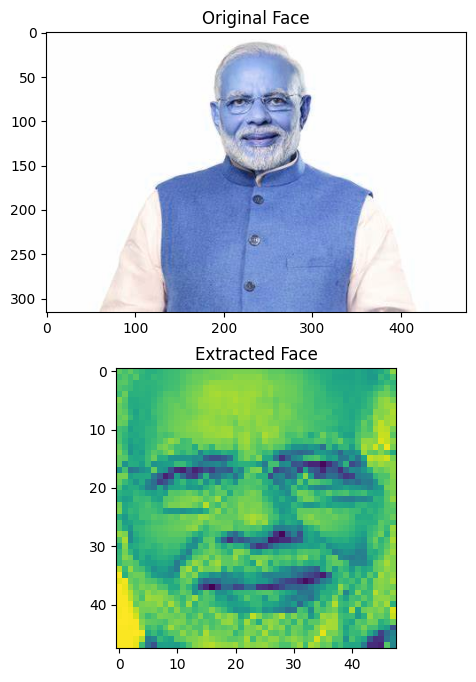

In [51]:
plt.figure(figsize=(12,8))

plt.subplot(211)
plt.title("Original Face")
plt.imshow(trump_face)

plt.subplot(212)
plt.title("Extracted Face")
plt.imshow(face)

plt.show()

<ipython-input-52-f6578ff0825d>:10: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-52-f6578ff0825d>:13: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


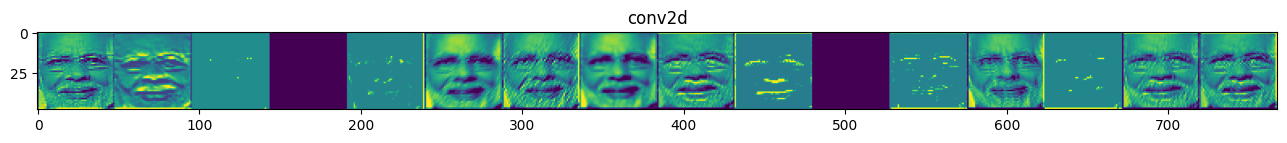

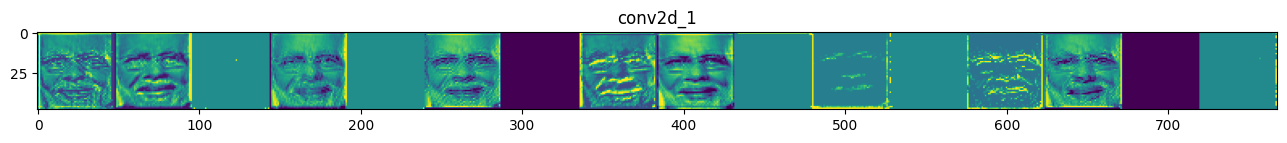

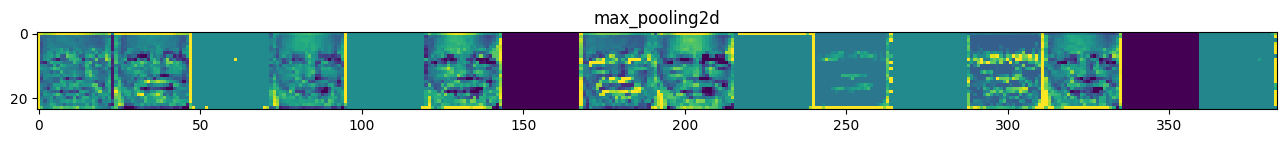

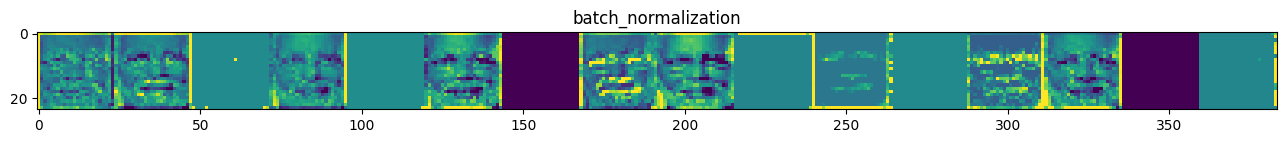

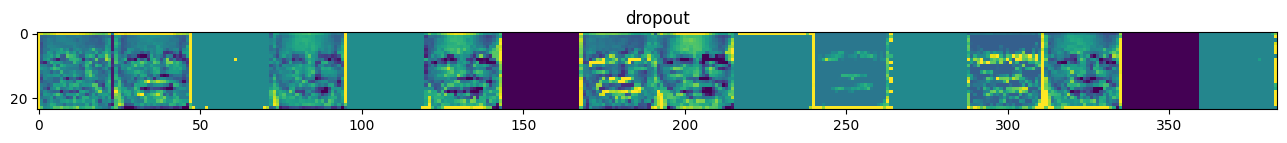

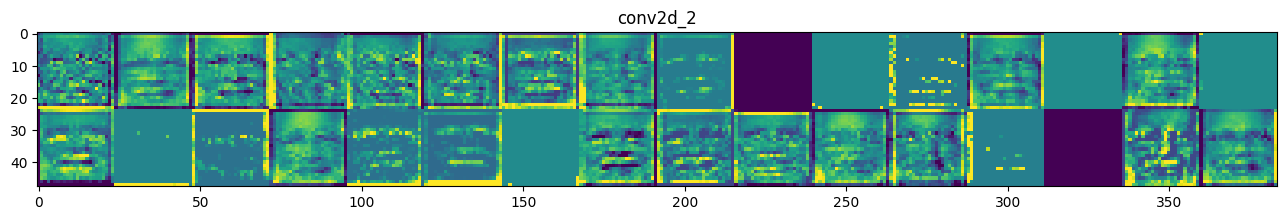

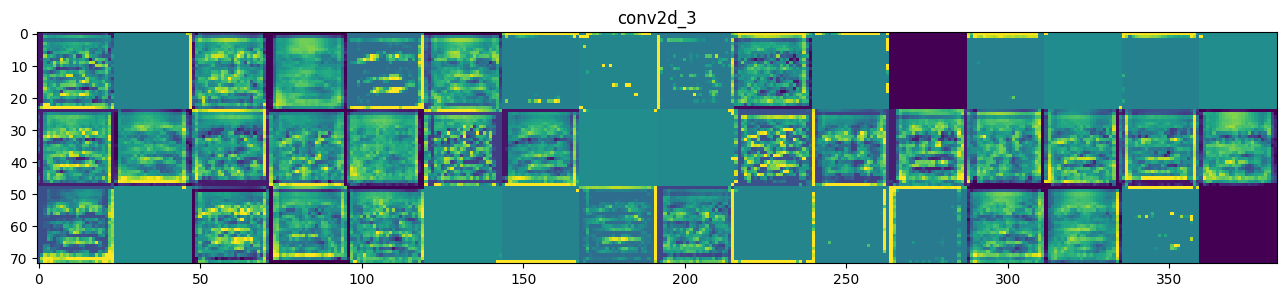

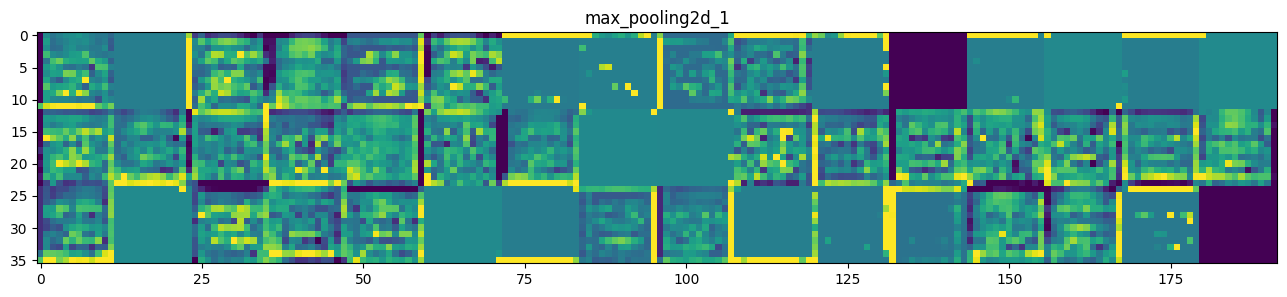

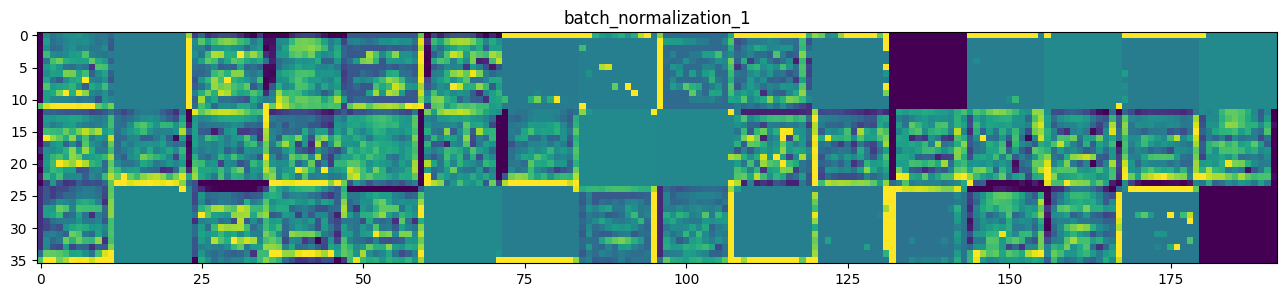

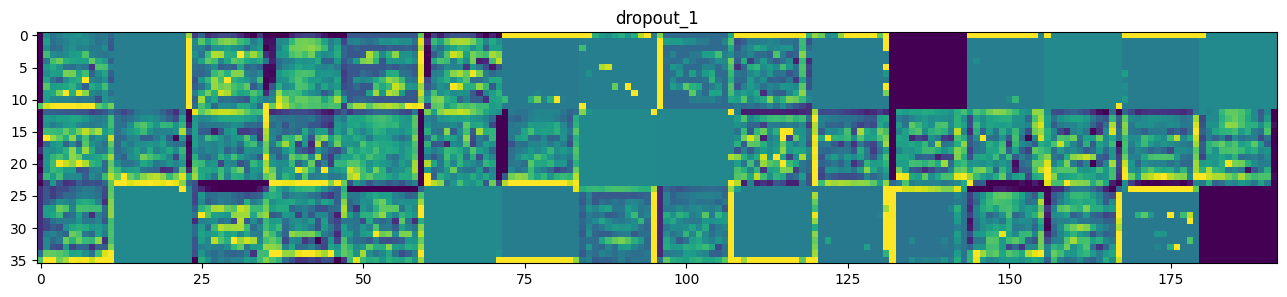

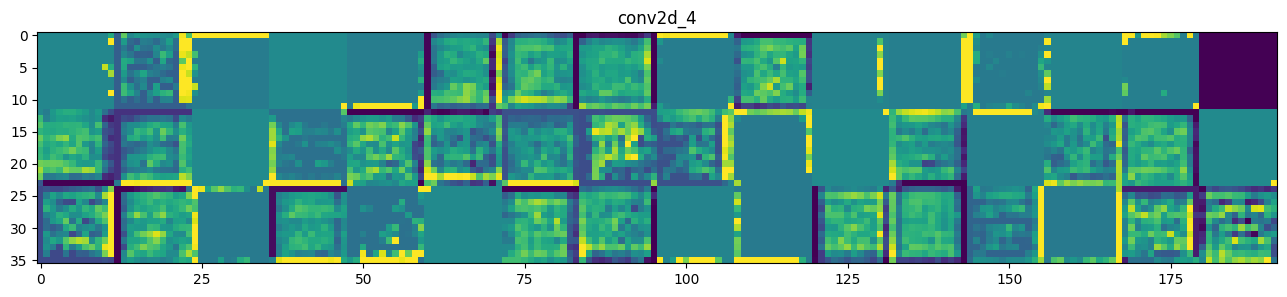

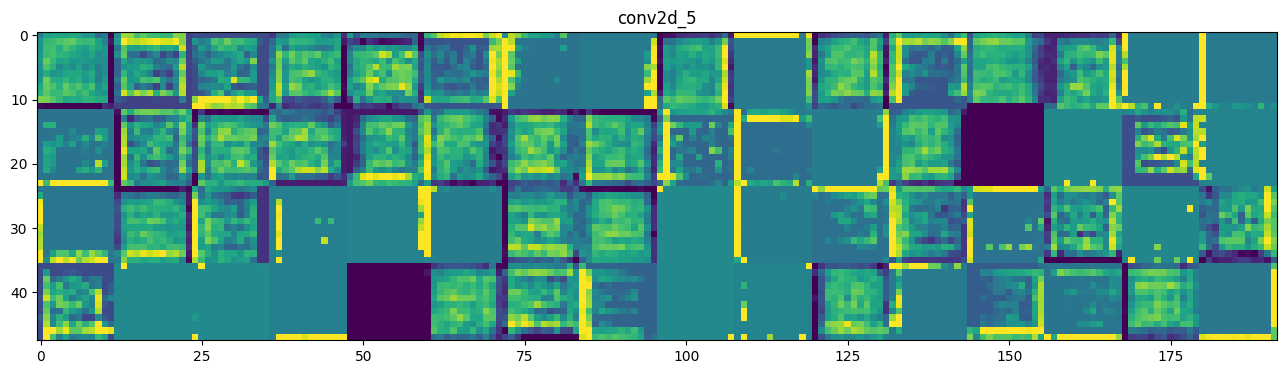

In [52]:
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### 1.6 Create and train the model

In [53]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

In [ ]:
#Creating 2nd model and training(fitting)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 256
epochs = 100

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(
    datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
    epochs = epochs,
    validation_data=(test_data, test_labels_one_hot)
)

### 1.7 Evaluate the model

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=2.0)
plt.plot(history.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### 1.8 Save and re-open the model

In [ ]:
#save the model weights
json_string = model.to_json()
model.save_weights('savedmodels/model_3.h5')
open('savedmodels/model_3.json', 'w').write(json_string)


In [ ]:
with open('savedmodels/model_3.json','r') as f:
    json = f.read()
model = model_from_json(json)

model.load_weights('savedmodels/model_3.h5')
print("Loaded model from disk")

### 1.9 Making a prediction on an image

In [ ]:
hanks = '/content/drive/MyDrive/Project/Image Dataset/hanks_vs.jpg'
hanks_face = cv2.imread(hanks)

In [ ]:
plt.imshow(cv2.cvtColor(hanks_face, cv2.COLOR_BGR2RGB))

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(detect_face(hanks_face)[0])
plt.show()

In [ ]:
for face in extract_face_features(detect_face(hanks_face)) :
    plt.figure(figsize=(10,10))
    plt.imshow(face)
    plt.show()

In [ ]:
for face in extract_face_features(detect_face(hanks_face)) :
    to_predict = np.reshape(face.flatten(), (1,48,48,1))
    res = model.predict(to_predict)
    result_num = np.argmax(res)
    print(result_num)

This corresponds to the Happy Labels which is a good prediction.

## 2. Inception

Architecture Inspired by : https://ieeexplore.ieee.org/document/7477450

In [54]:
input_img = Input(shape=(shape_x, shape_y, 1))

layer1 = Conv2D(10, (3, 3), padding='same', activation='relu')(input_img)
layer1_2 = Conv2D(20, (3, 3), padding='same', activation='relu')(layer1)
layer2 = MaxPooling2D(pool_size=(3, 3))(layer1_2)
bn1 = BatchNormalization()(layer2)

layer3 = Conv2D(30, (3, 3), padding='same', activation='relu')(bn1)
layer3_2 = Conv2D(40, (3, 3), padding='same', activation='relu')(layer3)
layer4 = MaxPooling2D(pool_size=(3, 3))(layer3_2)
bn2 = BatchNormalization()(layer4)

layer5 = Conv2D(50, (3, 3), padding='same', activation='relu')(bn2)
layer5_2 = Conv2D(60, (3, 3), padding='same', activation='relu')(layer5)
layer6 = MaxPooling2D(pool_size=(3, 3))(layer5_2)
bn3 = BatchNormalization()(layer6)

Conv11 = Conv2D(1, (1, 1), padding='same', activation='relu')(bn3)
Conv33 = Conv2D(4, (3, 3), padding='same', activation='relu')(bn3)
Conv332 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv33)
Conv55 = Conv2D(4, (5, 5), padding='same', activation='relu')(bn3)
Conv552 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv55)
#Pool33 = MaxPooling2D(pool_size=(3, 3))(bn3)
#ConvPool1 = Conv2D(4, (1, 1), padding='same', activation='relu')(Pool33)

intermediate1 = keras.layers.concatenate([Conv11, Conv332, Conv552], axis=1)

Conv2_11 = Conv2D(1, (1, 1), padding='same', activation='relu')(intermediate1)
Conv2_33 = Conv2D(4, (3, 3), padding='same', activation='relu')(intermediate1)
Conv2_332 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv2_33)
Conv2_55 = Conv2D(4, (5, 5), padding='same', activation='relu')(intermediate1)
Conv2_552 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv2_55)
#Pool2_33 = MaxPooling2D(pool_size=(3, 3))(intermediate1)
#ConvPool2 = Conv2D(4, (1, 1), padding='same', activation='relu')(Pool2_33)

intermediate2 = keras.layers.concatenate([Conv2_11, Conv2_332, Conv2_552], axis=1)

Conv3_11 = Conv2D(1, (1, 1), padding='same', activation='relu')(intermediate2)
Conv3_33 = Conv2D(4, (3, 3), padding='same', activation='relu')(intermediate2)
Conv3_332 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv3_33)
Conv3_55 = Conv2D(4, (5, 5), padding='same', activation='relu')(intermediate2)
Conv3_552 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv3_55)
#Pool3_33 = MaxPooling2D(pool_size=(3, 3))(intermediate2)
#ConvPool3 = Conv2D(4, (1, 1), padding='same', activation='relu')(Pool3_33)

intermediate3 = keras.layers.concatenate([Conv3_11, Conv3_332, Conv3_552], axis=1)

#Pool4 = MaxPooling2D(pool_size=(3, 3))(intermediate3)

Flat = Flatten()(intermediate3)

Dense1 = Dense(25, activation='relu')(Flat)
Dense2 = Dense(15, activation='relu')(Dense1)
Dense3 = Dense(7, activation='softmax')(Dense2)

In [55]:
model = Model([input_img], Dense3)

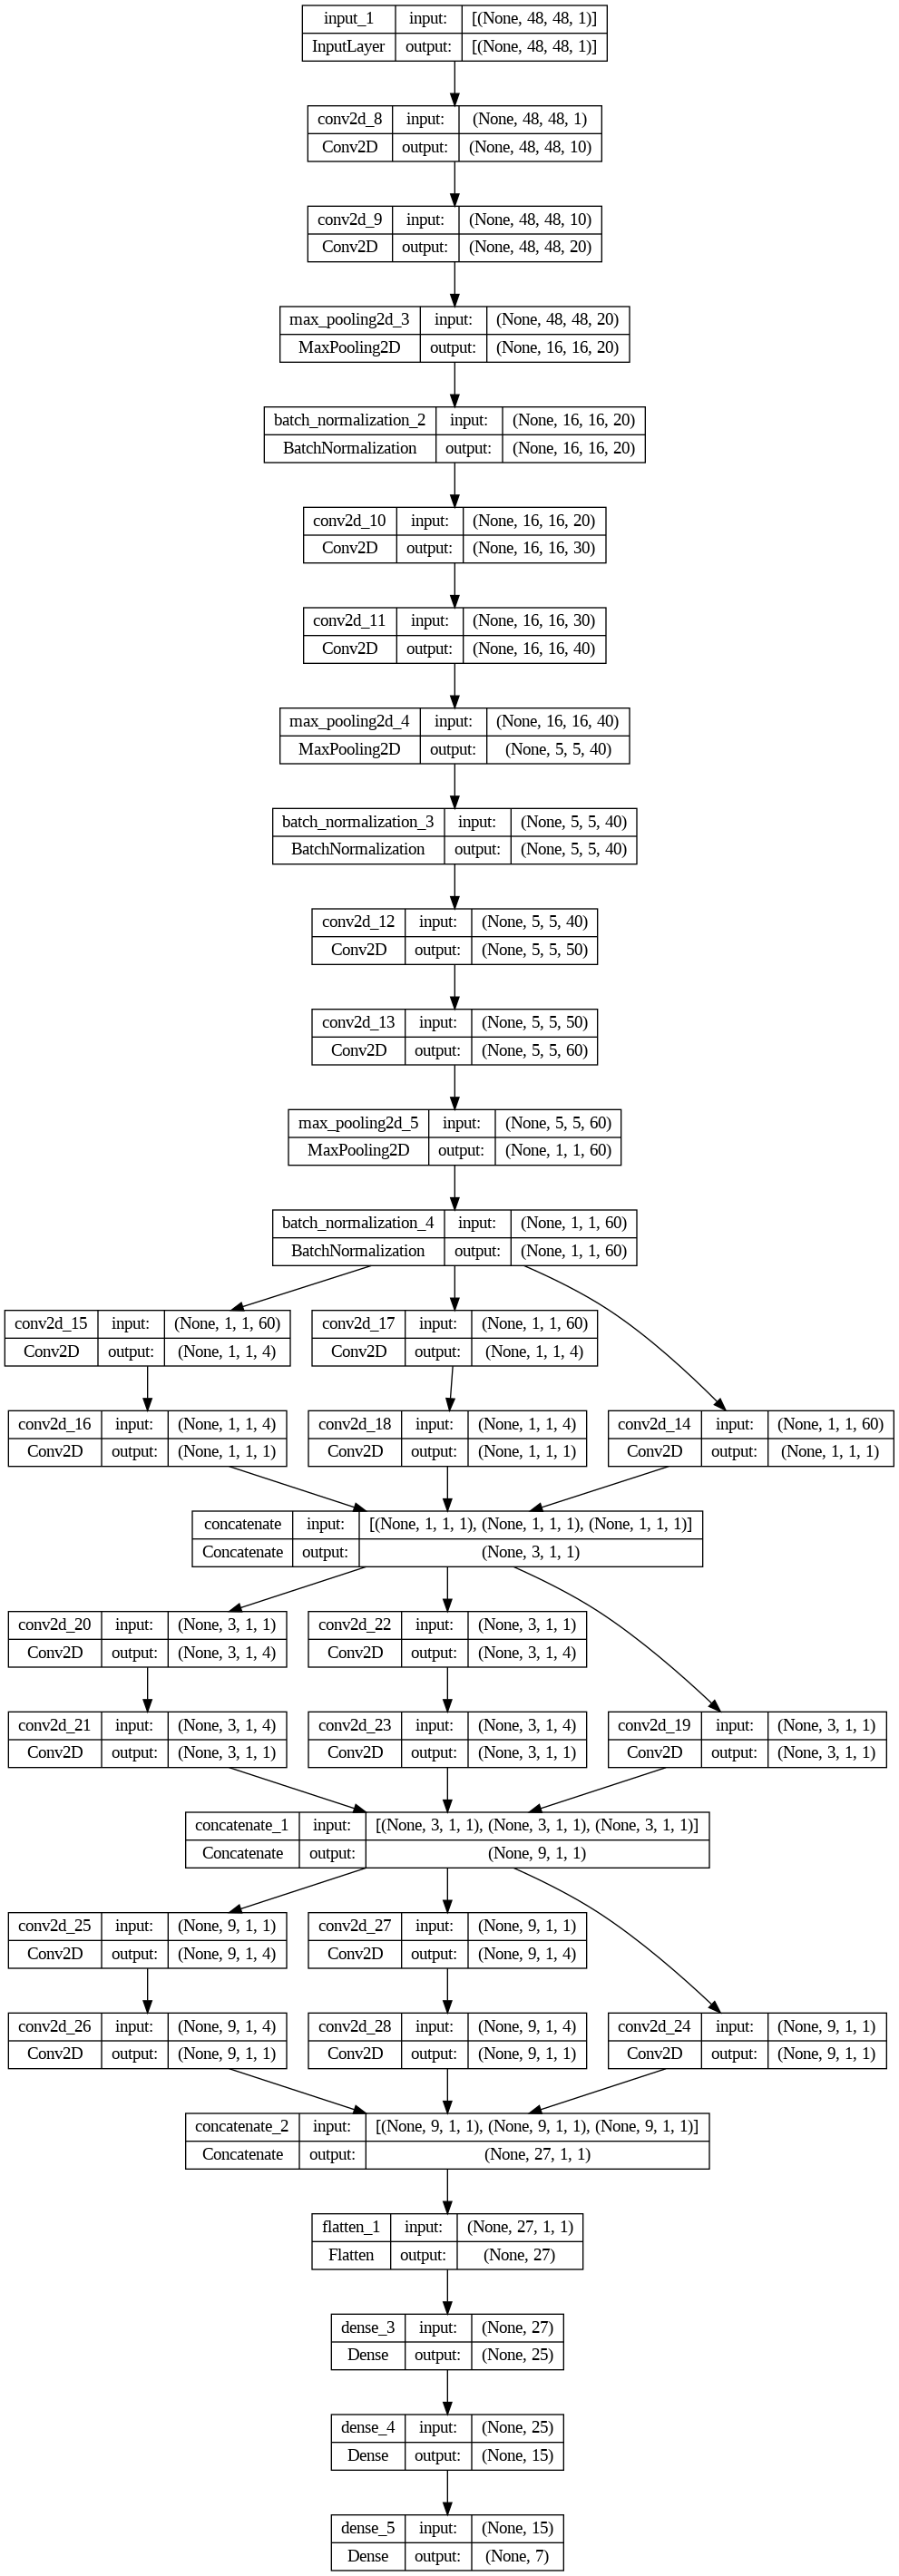

In [56]:
plot_model(model, to_file='/content/drive/MyDrive/Project/Image Dataset/model_plot_3.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 150

# Fit the model on the batches generated by datagen.flow().

In [ ]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

history = model.fit_generator(
    datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
    epochs = epochs,
    validation_data=(test_data, test_labels_one_hot)
)

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=2.0)
plt.plot(history.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
#save the model weights
json_string = model.to_json()
model.save_weights('savedmodels/model_deep_2.h5')
open('savedmodels/model_deep_2.json', 'w').write(json_string)
#model.save_weights(local_path + 'savedmodels/Emotion_Face_Detection_Model.h5')

In [ ]:
with open('savedmodels/model_deep_2.json','r') as f:
    json = f.read()
model = model_from_json(json)

model.load_weights('savedmodels/model_deep_2.h5')
print("Loaded model from disk")

## 3. X-Ception

In [57]:
def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 728] :

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

        x = keras.layers.Add()([x, residual])
        previous_block_activation = x

    return x

In [58]:
def middle_flow(x, num_blocks=8) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

In [59]:
def exit_flow(x, num_classes=7) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return x

In [60]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

In [61]:
xception = Model(inputs, outputs)

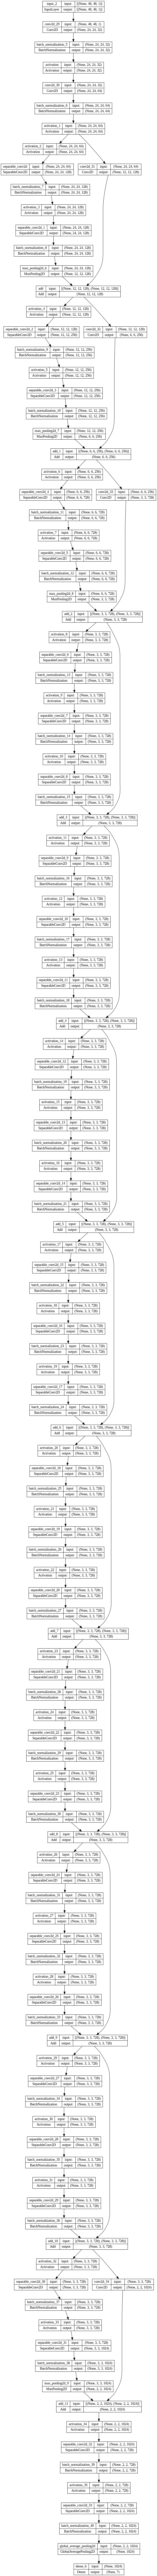

In [62]:
plot_model(xception, to_file='/content/drive/MyDrive/Project/Image Dataset/model_plot_4.png', show_shapes=True, show_layer_names=True)

In [63]:
xception.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_29 (Conv2D)          (None, 24, 24, 32)           320       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_5 (Bat  (None, 24, 24, 32)           128       ['conv2d_29[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 24, 24, 32)           0         ['batch_normalization_5[

In [ ]:
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 150

In [ ]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

history = xception.fit_generator(
    datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
    epochs = epochs,
    validation_data=(test_data, test_labels_one_hot)
)

#### Model

The model we have chosen is an **XCeption** model, since it outperformed the other approaches we developed so far. We tuned the model with :
- Data augmentation
- Early stopping
- Decreasing learning rate on plateau
- L2-Regularization
- Class weight balancing
- And kept the best model

As you might have understood, the aim was to limit overfitting as much as possible in order to obtain a robust model.

- To know more on how we prevented overfitting, check this article : https://maelfabien.github.io/deeplearning/regu/
- To know more on the **XCeption** model, check this article : https://maelfabien.github.io/deeplearning/xception/



The XCeption architecture is based on DepthWise Separable convolutions that allow to train much fewer parameters, and therefore reduce training time on Colab's GPUs to less than 90 minutes.


When it comes to applying CNNs in real life application, being able to explain the results is a great challenge. We can indeed  plot class activation maps, which display the pixels that have been activated by the last convolution layer. We notice how the pixels are being activated differently depending on the emotion being labeled. The happiness seems to depend on the pixels linked to the eyes and mouth, whereas the sadness or the anger seem for example to be more related to the eyebrows.



## Performance

The set of emotions we are trying to predict are the following :
- Happiness
- Sadness
- Fear
- Disgust
- Surprise
- Neutral
- Anger

The models have been trained on Google Colab using free GPUs.

|       Features                          |   Accuracy    |
|-----------------------------------------|---------------|
| Simple Deep Learning Architecture       |     62.7%     |
| Inception Architecture                  |     64.5%     |
| Xception Architecture                   |     71.1%     |
